In [3]:
import numpy as np
import time
from numpy import ones,vstack
from numpy.linalg import lstsq

import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from random import random, randint, uniform

import os
import glob
import shutil

import json

from statistics import median

In [4]:
def parse_trace(trace_file):
    last_state = {}
    with open(trace_file, "r") as f:
        all_lines = f.readlines()
        final_state_line = all_lines[-2].strip().replace("(", "").replace(")", "").split(" ")
        for item in final_state_line:
            pair = item.split("=")
            last_state[pair[0]] = float(pair[1])
    
    return last_state

In [32]:
num_instances = 10
horizons = [2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
time_budgets = [30, 60, 300, 600, 1800]

dfolder = "benchmarks/flight/quality_evolution"
    
h_averages = [[] for i in range(len(time_budgets)+2)]
for h in horizons:
    
    h_list = [[] for i in range(len(time_budgets)+2)]
    for pnum in range(num_instances):
        max_k = len(glob.glob(dfolder + "/solution_{}_{}_*.npt".format(pnum, h))) - 1
        
        solution_k = [0 for i in range(len(time_budgets)+2)]
        solution_k[-1] = max_k
        
        total_time = 0
        for k in range(max_k):
            with open(dfolder + "/solution_{}_{}_{}.json".format(pnum, h, k), "r") as f:
                json_str = f.read()
            user_time = json.loads(json_str)["user_time"]
            total_time += user_time
            
            for i in range(len(time_budgets)):
                tb = time_budgets[i]
                if total_time <= tb:
                    solution_k[i+1] = k                    
        
        for i in range(len(time_budgets)+2):
            k = solution_k[i]
            solution = parse_trace(dfolder + "/solution_{}_{}_{}.npt".format(pnum, h, k))
            h_list[i] += [math.sqrt(solution['roughness'])]
            #h_list[i] += [math.sqrt(solution['roughness'])/h]

                            
    for i in range(len(time_budgets)+2):
        h_averages[i] += [sum(h_list[i])/len(h_list[i])]


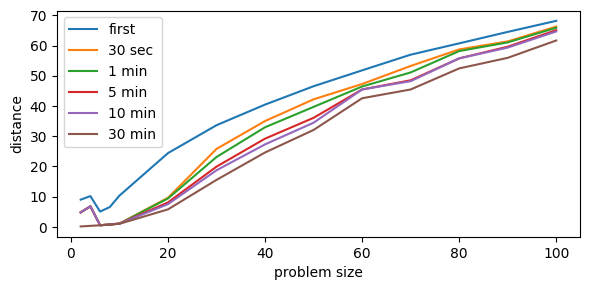

In [33]:
fig, ax = plt.subplots(figsize=(6,3))

labels = ["first", "30 sec", "1 min", "5 min", "10 min", "30 min"]

for i in range(len(labels)):
    ax.plot(horizons, h_averages[i], label=labels[i])


ax.set_ylabel("distance")
ax.set_xlabel("problem size")

ax.legend(loc="best")

fig.tight_layout()
plt.savefig("BandB2.pdf",bbox_inches='tight')

In [30]:
instances = [(4, 10), (6, 50), (5, 100)]
dfolder = "benchmarks/flight/c_roughness_1800"
    

roughness = {}
times = {}
for inst in instances:
    pnum = inst[0]
    h = inst[1]
    
    roughness[inst] = []
    times[inst] = []
    max_k = len(glob.glob(dfolder + "/solution_{}_{}_*.npt".format(pnum, h))) - 1

    total_time = 0
    for i in range(max_k):
        with open(dfolder + "/solution_{}_{}_{}.json".format(pnum, h, i), "r") as f:
            json_str = f.read()
        user_time = json.loads(json_str)["user_time"]
        total_time += user_time
        trace = parse_trace(dfolder + "/solution_{}_{}_{}.npt".format(pnum, h, i))

        roughness[inst] += [math.sqrt(trace['roughness'])/h]
        times[inst] += [total_time]

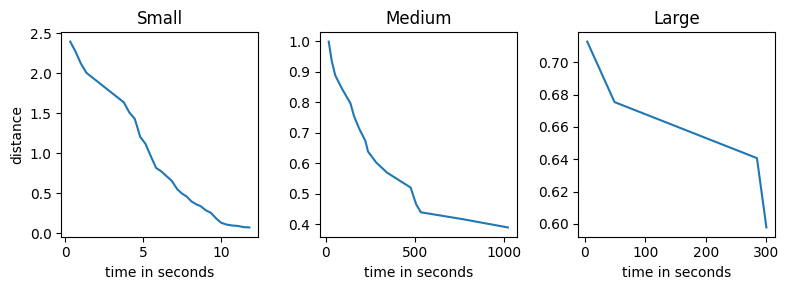

In [31]:
fig, axs = plt.subplots(1,3, figsize=(8,3))

axs[0].set_title("Small")
axs[0].set_ylabel("distance")
axs[1].set_title("Medium")
axs[2].set_title("Large")

for i in range(len(instances)):
    axs[i].set_xlabel("time in seconds")
    axs[i].plot(times[instances[i]], roughness[instances[i]])


fig.tight_layout()
plt.savefig("quality_vs_time_norm.pdf",bbox_inches='tight')